In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder


# Load data
df = pd.read_pickle('final_merged_stock_data_filtered_2022_2023.pkl')

In [2]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Splitting the dataset
train_df = df[df['Date'].dt.year == 2022].copy()
test_df = df[df['Date'].dt.year == 2023].copy()

In [3]:
metrics = [
    'Revenue  (ttm)', 'Diluted EPS  (ttm)', 'Trailing Annual Dividend Yield 3', 
    'Return on Equity  (ttm)', 'Total Debt/Equity  (mrq)', 
    'Levered Free Cash Flow  (ttm)', 'Close'
]

# Create the cleaned datasets
def clean_data(df):
    columns_needed = [
        'Ticker', 'Date', 'Revenue  (ttm)', 'Diluted EPS  (ttm)',
        'Trailing Annual Dividend Yield 3', 'Return on Equity  (ttm)',
        'Total Debt/Equity  (mrq)', 'Levered Free Cash Flow  (ttm)', 'Close'
    ]
    
    df_clean = df[columns_needed].copy()
    for col in columns_needed:
        if col not in ['Ticker', 'Date']:
            df_clean[col] = pd.to_numeric(
                df_clean[col].replace({'%': '', ',': '', 'M': 'e6', 'B': 'e9'}, regex=True),
                errors='coerce'
            )
    df_clean.dropna(inplace=True)
    return df_clean

train_clean = clean_data(train_df)
test_clean = clean_data(test_df)

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#Linear Regression Model

# Drop non-numeric columns explicitly
X_train = train_clean.drop(['Close', 'Ticker', 'Date', 'Stock_Type'], axis=1, errors='ignore')
y_train = train_clean['Close']

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate training performance
y_pred_train = model.predict(X_train)
print(f'Training R²: {r2_score(y_train, y_pred_train):.4f}')

Training R²: 0.8517


In [6]:
# Define Scenario Parameters 

scenarios = {
    "Base_Case": {
        "volatility": 0.2,
        "interest_rate": 0.03,
        "growth_revenue_quantile": 0.75,
        "value_max_debt_equity": 0.5,
        "income_min_dividend_yield": 3,
        "allocations": {"Growth": 0.7, "Value": 0.2, "Income": 0.1}
    },
    "Recession": {
        "volatility": 0.4,
        "interest_rate": 0.01,
        "growth_revenue_quantile": 0.8,
        "value_max_debt_equity": 0.3,
        "income_min_dividend_yield": 4,
        "allocations": {"Growth": 0.4, "Value": 0.3, "Income": 0.3}  # more defensive
    },
    "Expansion": {
        "volatility": 0.15,
        "interest_rate": 0.05,
        "growth_revenue_quantile": 0.7,
        "value_max_debt_equity": 0.6,
        "income_min_dividend_yield": 2.5,
        "allocations": {"Growth": 0.8, "Value": 0.15, "Income": 0.05}  # more aggressive
    },
}

In [7]:
def calculate_scores(df, stock_type):
    df = df.copy()
    
    if stock_type == 'Growth':
        # Growth stocks: Prioritize EPS growth, ROE, and Revenue growth
        df['Score'] = (
            (df['Diluted EPS  (ttm)'].rank(pct=True) * 0.4) +
            (df['Return on Equity  (ttm)'].rank(pct=True) * 0.3) +
            (df['Revenue  (ttm)'].rank(pct=True) * 0.3)
        )
        
    elif stock_type == 'Value':
        # Value stocks: Lower debt, good earnings, moderate dividends
        df['Score'] = (
            (df['Diluted EPS  (ttm)'].rank(pct=True) * 0.3) +
            ((1 / df['Total Debt/Equity  (mrq)']).rank(pct=True) * 0.4) +
            (df['Revenue  (ttm)'].rank(pct=True) * 0.3)
        )

    elif stock_type == 'Income':
        # Income stocks: Highest dividend yield, sustainable cash flow, moderate debt
        df['Score'] = (
            (df['Trailing Annual Dividend Yield 3'].rank(pct=True) * 0.6) +
            ((1 / df['Total Debt/Equity  (mrq)']).rank(pct=True) * 0.2) +
            (df['Levered Free Cash Flow  (ttm)'].rank(pct=True) * 0.2)
        )

    return df.sort_values('Score', ascending=False)

In [8]:
# Conditions Function

def classify_stocks(df, train_df, scenario_params):
    conditions = [
        (df['Trailing Annual Dividend Yield 3'] < 1) & 
        (df['Revenue  (ttm)'] > train_df['Revenue  (ttm)'].quantile(scenario_params['growth_revenue_quantile'])),

        (df['Diluted EPS  (ttm)'] > train_df['Diluted EPS  (ttm)'].median()) &
        (df['Total Debt/Equity  (mrq)'] < scenario_params['value_max_debt_equity']),

        (df['Trailing Annual Dividend Yield 3'] >= scenario_params['income_min_dividend_yield'])
    ]

    labels = ['Growth', 'Value', 'Income']
    df['Stock_Type'] = np.select(conditions, labels, default='Value')

    return df

In [9]:
def evaluate_portfolio(scenario, test_df, train_df):
    scenario_params = scenarios[scenario]

    # Aggregate test data
    agg_test_df = test_df.groupby('Ticker').agg({
        'Revenue  (ttm)': 'mean',
        'Diluted EPS  (ttm)': 'mean',
        'Trailing Annual Dividend Yield 3': 'mean',
        'Return on Equity  (ttm)': 'mean',
        'Total Debt/Equity  (mrq)': 'mean',
        'Levered Free Cash Flow  (ttm)': 'mean',
        'Close': 'mean'
    }).reset_index()

    # Scenario-specific classification
    classified_df = classify_stocks(agg_test_df, train_df, scenario_params)

    # Score stocks 
    growth_scored = calculate_scores(classified_df[classified_df['Stock_Type']=='Growth'], 'Growth').head(30)
    value_scored = calculate_scores(classified_df[classified_df['Stock_Type']=='Value'], 'Value').head(20)
    income_scored = calculate_scores(classified_df[classified_df['Stock_Type']=='Income'], 'Income').head(10)

    portfolio_df = pd.concat([growth_scored, value_scored, income_scored])
    
    # Dynamically allocated based on scenario
    portfolio_df['Allocation %'] = 0.0
    
    allocations = scenario_params['allocations']
    
    portfolio_df.loc[portfolio_df['Stock_Type']=='Growth', 'Allocation %'] = allocations['Growth'] / len(growth_scored)
    portfolio_df.loc[portfolio_df['Stock_Type']=='Value', 'Allocation %'] = allocations['Value'] / len(value_scored)
    portfolio_df.loc[portfolio_df['Stock_Type']=='Income', 'Allocation %'] = allocations['Income'] / len(income_scored)

    return portfolio_df[['Ticker', 'Revenue  (ttm)', 'Diluted EPS  (ttm)', 
                         'Trailing Annual Dividend Yield 3', 'Stock_Type', 'Allocation %']]

In [10]:
# Evaluating portfolio under recession conditions:
portfolio_recession = evaluate_portfolio("Recession", test_clean, train_clean)
print(portfolio_recession)

    Ticker  Revenue  (ttm)  Diluted EPS  (ttm)  \
197    HCA    7.060000e+10               22.01   
272   META    1.645000e+11               23.86   
60   BRK-B    3.714300e+11               41.27   
93     COR    3.031900e+11                7.05   
1     AAPL    3.957600e+11                6.31   
80    CHTR    5.508000e+10               34.96   
287   MSFT    2.618000e+11               12.42   
94    COST    2.640900e+11               17.14   
189   GOOG    3.500200e+11                8.05   
190  GOOGL    3.500200e+11                8.03   
255    LLY    4.504000e+10               11.68   
295   NFLX    3.900000e+10               19.85   
31    AMZN    6.379600e+11                5.54   
400    UAL    5.706000e+10                9.45   
304   NVDA    1.305000e+11                2.94   
281    MOH    3.916000e+10               20.43   
429    WMT    6.809800e+11                2.41   
384    TMO    4.288000e+10               16.52   
401   UBER    4.398000e+10                4.56   


In [11]:
# Evaluating portfolio under base-case conditions:
portfolio_base = evaluate_portfolio("Base_Case", test_clean, train_clean)
print(portfolio_base)

    Ticker  Revenue  (ttm)  Diluted EPS  (ttm)  \
197    HCA    7.060000e+10               22.01   
272   META    1.645000e+11               23.86   
60   BRK-B    3.714300e+11               41.27   
93     COR    3.031900e+11                7.05   
80    CHTR    5.508000e+10               34.96   
94    COST    2.640900e+11               17.14   
1     AAPL    3.957600e+11                6.31   
287   MSFT    2.618000e+11               12.42   
189   GOOG    3.500200e+11                8.05   
190  GOOGL    3.500200e+11                8.03   
255    LLY    4.504000e+10               11.68   
295   NFLX    3.900000e+10               19.85   
281    MOH    3.916000e+10               20.43   
265     MA    2.817000e+10               13.91   
31    AMZN    6.379600e+11                5.54   
400    UAL    5.706000e+10                9.45   
409      V    3.680000e+10                9.91   
304   NVDA    1.305000e+11                2.94   
384    TMO    4.288000e+10               16.52   


In [12]:
# Evaluating portfolio under expansion conditions:
portfolio_expansion = evaluate_portfolio("Expansion", test_clean, train_clean)
print(portfolio_expansion)

    Ticker  Revenue  (ttm)  Diluted EPS  (ttm)  \
197    HCA    7.060000e+10               22.01   
272   META    1.645000e+11               23.86   
60   BRK-B    3.714300e+11               41.27   
80    CHTR    5.508000e+10               34.96   
94    COST    2.640900e+11               17.14   
93     COR    3.031900e+11                7.05   
287   MSFT    2.618000e+11               12.42   
1     AAPL    3.957600e+11                6.31   
295   NFLX    3.900000e+10               19.85   
255    LLY    4.504000e+10               11.68   
189   GOOG    3.500200e+11                8.05   
190  GOOGL    3.500200e+11                8.03   
265     MA    2.817000e+10               13.91   
281    MOH    3.916000e+10               20.43   
400    UAL    5.706000e+10                9.45   
409      V    3.680000e+10                9.91   
31    AMZN    6.379600e+11                5.54   
304   NVDA    1.305000e+11                2.94   
384    TMO    4.288000e+10               16.52   


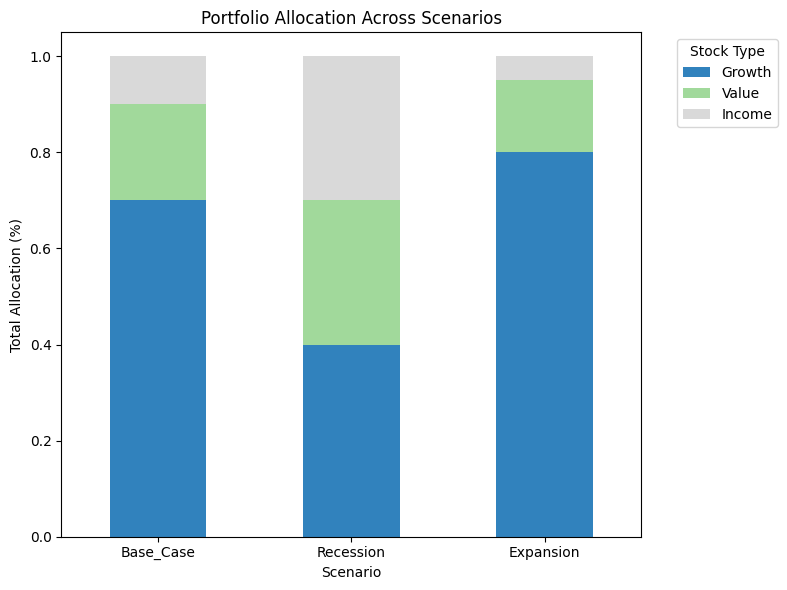

In [13]:
import matplotlib.pyplot as plt

scenarios_list = ['Base_Case', 'Recession', 'Expansion']
allocation_summary = pd.DataFrame(columns=['Growth', 'Value', 'Income'], index=scenarios_list)

for scenario in scenarios_list:
    port_df = evaluate_portfolio(scenario, test_clean, train_clean)
    alloc_sums = port_df.groupby('Stock_Type')['Allocation %'].sum()
    allocation_summary.loc[scenario] = alloc_sums

# Plot
allocation_summary.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20c', rot=0)

plt.title('Portfolio Allocation Across Scenarios')
plt.ylabel('Total Allocation (%)')
plt.xlabel('Scenario')
plt.legend(title='Stock Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('scenario_allocations.png', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
# SPY
spy = pd.read_pickle('SPY_18_23.pkl')

start_date = '2023-01-03'
end_date = '2023-12-29'

spy_start_price = spy.loc[start_date]
spy_end_price = spy.loc[end_date]

if isinstance(spy_start_price, pd.Series):
    spy_start_price = spy_start_price.iloc[0]

if isinstance(spy_end_price, pd.Series):
    spy_end_price = spy_end_price.iloc[0]

spy_return = ((spy_end_price - spy_start_price) / spy_start_price) * 100

In [25]:
initial_investment = 10_000_000

def calculate_portfolio_return(portfolio_df, test_df, start_date, end_date):
    start_prices = test_df[test_df['Date'] == start_date].set_index('Ticker')['Close']
    end_prices = test_df[test_df['Date'] == end_date].set_index('Ticker')['Close']

    # Align prices
    portfolio_df['Start_Price'] = portfolio_df['Ticker'].map(start_prices)
    portfolio_df['End_Price'] = portfolio_df['Ticker'].map(end_prices)

    # Drop rows with missing prices
    portfolio_df.dropna(subset=['Start_Price', 'End_Price'], inplace=True)

    # Calculate returns
    portfolio_df['Stock_Return'] = ((portfolio_df['End_Price'] - portfolio_df['Start_Price']) / portfolio_df['Start_Price']) * 100
    portfolio_df['Weighted_Return'] = portfolio_df['Stock_Return'] * (portfolio_df['Allocation %'])

    total_portfolio_return = portfolio_df['Weighted_Return'].sum()
    final_value = initial_investment * (1 + total_portfolio_return / 100)

    return total_portfolio_return, final_value

# Calculate return for each scenario:
rec_return, rec_value = calculate_portfolio_return(portfolio_recession, test_clean, start_date, end_date)
base_return, base_value = calculate_portfolio_return(portfolio_base, test_clean, start_date, end_date)
exp_return, exp_value = calculate_portfolio_return(portfolio_expansion, test_clean, start_date, end_date)

In [26]:
# Print results:
print("\n=== Portfolio Performance Under Different Economic Scenarios ===")

print("\nScenario: Recession")
print(f"Portfolio Return: {rec_return:.2f}%")
print(f"Portfolio Final Value: ${rec_value:,.2f}")

print("\nScenario: Base Case")
print(f"Portfolio Return: {base_return:.2f}%")
print(f"Portfolio Final Value: ${base_value:,.2f}")

print("\nScenario: Expansion")
print(f"Portfolio Return: {exp_return:.2f}%")
print(f"Portfolio Final Value: ${exp_value:,.2f}")

# Clearly verified SPY benchmark (using your original working method)
spy_final_value = initial_investment * (1 + spy_return / 100)

print("\n=== S&P 500 (SPY) Benchmark ===")
print(f"SPY Return: {spy_return:.2f}%")
print(f"SPY Final Value: ${spy_final_value:,.2f}")


=== Portfolio Performance Under Different Economic Scenarios ===

Scenario: Recession
Portfolio Return: 28.33%
Portfolio Final Value: $12,832,768.71

Scenario: Base Case
Portfolio Return: 44.43%
Portfolio Final Value: $14,443,489.52

Scenario: Expansion
Portfolio Return: 52.03%
Portfolio Final Value: $15,203,148.33

=== S&P 500 (SPY) Benchmark ===
SPY Return: 26.71%
SPY Final Value: $12,670,922.43
